In [1]:
import hashlib
import time
import random
import math
import os
from sklearn.neural_network import MLPClassifier
import numpy as np
import pandas as pd
from IPython.display import display
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from collections.abc import Mapping, Container
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

In [2]:
def get_memory_usage(bf):
    """Estimate memory used by each filter."""
    size = sys.getsizeof(bf)

    # classical bit/count arrays
    if hasattr(bf, 'bit_array'):
        size += sys.getsizeof(bf.bit_array)
    if hasattr(bf, 'count_array'):
        size += sys.getsizeof(bf.count_array)

    # Sandwich: just sum its two parts
    if hasattr(bf, 'small') and hasattr(bf, 'ml'):
        return get_memory_usage(bf.ml) + get_memory_usage(bf.small)

    # any ML‐based filter with a .model
    if hasattr(bf, 'model'):
        mdl = bf.model

        # neural networks & logistic regression have coefs_ / intercepts_
        if hasattr(mdl, 'coefs_'):
            for coef in mdl.coefs_:
                size += coef.nbytes
            for intercept in mdl.intercepts_:
                size += intercept.nbytes

        # random forests have many tree estimators
        if hasattr(mdl, 'estimators_'):
            for tree_est in mdl.estimators_:
                tree = tree_est.tree_
                # pick the big arrays inside each tree
                for arr_name in ('threshold', 'feature', 'children_left',
                                 'children_right', 'value'):
                    arr = getattr(tree, arr_name, None)
                    if isinstance(arr, np.ndarray):
                        size += arr.nbytes

    return size

In [3]:
class StandardBloomFilter:
    def __init__(self, n, fp_rate):
        self.size = self._get_size(n, fp_rate)
        self.hash_count = self._get_hash_count(self.size, n)
        self.bit_array = [0] * self.size

    def _hashes(self, item):
        return [hashlib.sha256(f"{item}{i}".encode()).hexdigest() for i in range(self.hash_count)]

    def _get_size(self, n, p):
        m = -(n * math.log(p)) / (math.log(2)**2)
        return int(m)

    def _get_hash_count(self, m, n):
        return int((m / n) * math.log(2))

    def add(self, item):
        for i in range(self.hash_count):
            idx = int(hashlib.md5(f"{item}{i}".encode()).hexdigest(), 16) % self.size
            self.bit_array[idx] = 1

    def query(self, item):
        for i in range(self.hash_count):
            idx = int(hashlib.md5(f"{item}{i}".encode()).hexdigest(), 16) % self.size
            if self.bit_array[idx] == 0:
                return False
        return True


In [4]:
class CountingBloomFilter:
    def __init__(self, n, fp_rate):
        self.size = self._get_size(n, fp_rate)
        self.hash_count = self._get_hash_count(self.size, n)
        self.count_array = [0] * self.size

    def _get_size(self, n, p):
        return int(-(n * math.log(p)) / (math.log(2)**2))

    def _get_hash_count(self, m, n):
        return int((m / n) * math.log(2))

    def add(self, item):
        for i in range(self.hash_count):
            idx = int(hashlib.md5(f"{item}{i}".encode()).hexdigest(), 16) % self.size
            self.count_array[idx] += 1

    def remove(self, item):
        for i in range(self.hash_count):
            idx = int(hashlib.md5(f"{item}{i}".encode()).hexdigest(), 16) % self.size
            self.count_array[idx] = max(0, self.count_array[idx] - 1)

    def query(self, item):
        for i in range(self.hash_count):
            idx = int(hashlib.md5(f"{item}{i}".encode()).hexdigest(), 16) % self.size
            if self.count_array[idx] == 0:
                return False
        return True


In [5]:
class BaseMLBloomFilter:
    def __init__(self, model):
        self.model = model
        self.trained = False

    def _featurize(self, item):
        arr = [ord(c) / 255.0 for c in item[:50]] + [0.0]*(50 - len(item))
        length = len(item) / 50.0
        hash_val = int(hashlib.md5(item.encode()).hexdigest(), 16) % 1000000 / 1000000.0
        return np.array(arr + [length, hash_val]).reshape(1, -1)

    def train(self, positives, negatives):
        X = np.vstack([self._featurize(x) for x in positives + negatives])
        y = np.array([1]*len(positives) + [0]*len(negatives))
        self.model.fit(X, y)
        self.trained = True

    def query(self, item):
        if not self.trained:
            raise ValueError("Model must be trained before querying.")
        x = self._featurize(item)
        return bool(self.model.predict(x)[0])

    def add(self, item):
        pass


In [6]:
class NeuralNetworkBloomFilter(BaseMLBloomFilter):
    def __init__(self):
        model = MLPClassifier(hidden_layer_sizes=(20,), max_iter=300, alpha=0.001)
        super().__init__(model)


In [7]:
# Logistic Regression Bloom Filter
class LogisticRegressionBloomFilter(BaseMLBloomFilter):
    def __init__(self):
        model = LogisticRegression(max_iter=200)
        super().__init__(model)

In [8]:
class RandomForestBloomFilter(BaseMLBloomFilter):
    def __init__(self, max_model_size_bytes=1500000, n_estimators=100, max_depth=10):
        self.size_limit = max_model_size_bytes
        self.base_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        super().__init__(self.base_model)

    def train(self, positives, negatives):
        X = np.vstack([self._featurize(x) for x in positives + negatives])
        y = np.array([1]*len(positives) + [0]*len(negatives))
        
        # Try reducing depth to meet memory limit
        for depth in range(self.base_model.max_depth, 0, -1):
            model = RandomForestClassifier(
                n_estimators=self.base_model.n_estimators,
                max_depth=depth
            )
            model.fit(X, y)
            self.model = model
            size = get_memory_usage(self)
            if size <= self.size_limit:
                print(f"✅ depth={depth} fits: {size:,} bytes ≤ {self.size_limit:,}")
                self.trained = True
                return
            else:
                print(f"⚠️  depth={depth} exceeds: {size:,} bytes > {self.size_limit:,}")

        # fallback
        print("❌ Could not meet memory constraint, using depth=1")
        self.model = RandomForestClassifier(n_estimators=self.base_model.n_estimators, max_depth=1)
        self.model.fit(X, y)
        self.trained = True



In [9]:
class SVMBloomFilter(BaseMLBloomFilter):
    def __init__(self):
        model = SVC(probability=True, kernel='linear', max_iter=1000)
        super().__init__(model)

In [10]:
from sklearn.linear_model import SGDClassifier

class SGDLogisticBloomFilter(BaseMLBloomFilter):
    def __init__(self):
        model = SGDClassifier(loss='log_loss', max_iter=1000)
        super().__init__(model)


In [11]:


class LightGBMBloomFilter(BaseMLBloomFilter):
    def __init__(self, max_model_size_bytes=1500000):
        self.size_limit = max_model_size_bytes
        model = lgb.LGBMClassifier(max_depth=7, n_estimators=100)
        super().__init__(model)

    def train(self, positives, negatives):
        X = np.vstack([self._featurize(x) for x in positives + negatives])
        y = np.array([1]*len(positives) + [0]*len(negatives))
        self.model.fit(X, y)
        size = get_memory_usage(self)
        if size > self.size_limit:
            print(f"⚠️ LightGBM model too large: {size:,} bytes")
        else:
            print(f"✅ LightGBM model fits: {size:,} bytes")
        self.trained = True


In [12]:
class SandwichBloomFilter:
    def __init__(self, ml_filter, positives, negatives, fp_rate_small=0.20):
        self.ml = ml_filter
        self.ml.train(positives, negatives)
        self.small = StandardBloomFilter(len(positives), fp_rate_small)
        self._initialize_small_filter(positives)

    def _initialize_small_filter(self, positives):
        for item in positives:
            if not self.ml.query(item):  # Only ML misses
                self.small.add(item)

    def add(self, item):
        pass

    def query(self, item):
        if self.ml.query(item):
            return True
        else:
            return self.small.query(item)



In [13]:
def human_readable_size(num_bytes, decimals=2):
    for unit in ('B','KB','MB','GB','TB'):
        if num_bytes < 1024.0:
            return f"{num_bytes:.{decimals}f} {unit}"
        num_bytes /= 1024.0
    return f"{num_bytes:.{decimals}f} PB"

def create_set(size):
    my_set = set()
    for i in range(size):
        my_set.add(i)
    return my_set
    

In [14]:
def evaluate(bf, positives, negatives):
    """Run insertions and then measure FP, FN, F1, timing, throughput, memory."""
    # — insert positives —
    for url in positives:
        bf.add(url)

    # — measure false positives —
    start = time.time()
    false_positives = sum(1 for url in negatives if bf.query(url) and url not in positives)
    elapsed = time.time() - start

    # — measure false negatives (only for ML filters) —
    false_negatives = 0
    true_positives = 0
    if isinstance(bf, BaseMLBloomFilter):
        for url in positives:
            if bf.query(url):
                true_positives += 1
            else:
                false_negatives += 1

    fpr = false_positives / len(negatives)
    fnr = false_negatives / len(positives) if positives else 0.0
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / len(positives) if positives else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    avg_query_time = elapsed / len(negatives)
    throughput = len(negatives) / elapsed if elapsed > 0 else float('inf')
    memory_bytes = get_memory_usage(bf)

    print(f"\n=== {bf.__class__.__name__} ===")
    print(f"Memory Usage:             {memory_bytes:,} bytes")
    print(f"False‐Positive Rate:      {fpr:.4%}")
    if isinstance(bf, BaseMLBloomFilter):
        print(f"False‐Negative Rate:      {fnr:.4%}")
        print(f"F1 Score:                 {f1_score:.4f}")
    print(f"Avg Query Time:           {avg_query_time:.6f} s")
    print(f"Throughput:               {throughput:,.0f} queries/s")

    return {
    'FP Rate': fpr,
    'FN Rate': fnr if isinstance(bf, BaseMLBloomFilter) else np.nan,
    'F1': f1_score if isinstance(bf, BaseMLBloomFilter) else np.nan,
    'Avg Time (s)': avg_query_time,
    'Throughput (q/s)': throughput,
    'Mem (bytes)': memory_bytes
}



In [15]:
def evaluate_dataset(dataset_name, pos_path, neg_path):
    print(f"\n🔍 {dataset_name} Bloom Filter Evaluation\n")

    with open(pos_path) as f:
        positives = f.read().splitlines()
    with open(neg_path) as f:
        negatives = f.read().splitlines()

    n = len(positives)
    size = get_memory_usage(create_set(n))

    # Define all filters
    ml_filters = [
        ("NeuralNet", NeuralNetworkBloomFilter()),
        ("LightGBM", LightGBMBloomFilter(max_model_size_bytes=size)),
        ("SGDLogistic", SGDLogisticBloomFilter()),
        ("SVM", SVMBloomFilter()),
         ("RandomForest", RandomForestBloomFilter(max_model_size_bytes=size, n_estimators=100, max_depth=7))
    ]

    classical_filters = [
        ("Standard", StandardBloomFilter(n, 0.1)),
        ("Counting", CountingBloomFilter(n, 0.1)),
    ]

    # Train ML filters
    for _, ml in ml_filters:
        ml.train(positives, negatives)

    filters = classical_filters + ml_filters

    # Add Sandwich filters
    filters += [
        (f"Sandwich-{name}", SandwichBloomFilter(bf, positives, negatives, 0.2))
        for name, bf in ml_filters
    ]

    # Evaluate all
    results = []
    for name, bf in filters:
        m = evaluate(bf, positives, negatives)
        results.append({
            "Filter":            name,
            "Mem (bytes)":       m["Mem (bytes)"],
            "FP Rate":           m["FP Rate"],
            "FN Rate":           m["FN Rate"],
            "Avg Time (s)":      m["Avg Time (s)"],
            "Throughput (q/s)":  m["Throughput (q/s)"],
            "F1":                m["F1"]
        })


    df = pd.DataFrame(results)
    display(df)
    return df


In [16]:
def plot_results(df, dataset_name):
    sns.set(style="whitegrid")

    # Create output directory for this dataset
    output_dir = f"plots/{dataset_name.replace(' ', '_')}"
    os.makedirs(output_dir, exist_ok=True)

    # 1. Save Individual Metric Plots

    def save_metric_plot(x_col, title, filename, data=df, palette="Blues_d"):
        plt.figure(figsize=(10, 6))
        sns.barplot(x=x_col, y='Filter', data=data, palette=palette)
        plt.title(title)
        plt.tight_layout()
        path = os.path.join(output_dir, filename)
        plt.savefig(path)
        plt.close()
        print(f"{title} plot saved to: {path}")

    save_metric_plot('Mem (bytes)', 'Memory Usage (bytes)', "memory_usage.png", palette="Blues_d")
    save_metric_plot('Avg Time (s)', 'Average Lookup Time (s)', "avg_lookup_time.png", palette="Greens_d")
    save_metric_plot('FP Rate', 'False Positive Rate', "false_positive_rate.png", palette="Reds_d")

    df_fnr = df.dropna(subset=['FN Rate'])
    if not df_fnr.empty:
        save_metric_plot('FN Rate', 'False Negative Rate (ML Filters Only)', "false_negative_rate.png", data=df_fnr, palette="Oranges_d")

    df_f1 = df.dropna(subset=['F1'])
    if not df_f1.empty:
        save_metric_plot('F1', 'F1 Score (ML Filters Only)', "f1_score.png", data=df_f1, palette="Purples_d")

    save_metric_plot('Throughput (q/s)', 'Throughput (queries/sec)', "throughput.png", palette="Greys_d")

    # 2. Combined Plot
    fig, axes = plt.subplots(3, 2, figsize=(16, 16))
    fig.suptitle(f'{dataset_name} Bloom Filter Evaluation Metrics', fontsize=20)

    sns.barplot(x='Mem (bytes)', y='Filter', data=df, ax=axes[0, 0], palette="Blues_d")
    axes[0, 0].set_title('Memory Usage (bytes)')

    sns.barplot(x='Avg Time (s)', y='Filter', data=df, ax=axes[0, 1], palette="Greens_d")
    axes[0, 1].set_title('Average Lookup Time (s)')

    sns.barplot(x='FP Rate', y='Filter', data=df, ax=axes[1, 0], palette="Reds_d")
    axes[1, 0].set_title('False Positive Rate')

    if not df_fnr.empty:
        sns.barplot(x='FN Rate', y='Filter', data=df_fnr, ax=axes[1, 1], palette="Oranges_d")
        axes[1, 1].set_title('False Negative Rate (ML Filters Only)')

    if not df_f1.empty:
        sns.barplot(x='F1', y='Filter', data=df_f1, ax=axes[2, 0], palette="Purples_d")
        axes[2, 0].set_title('F1 Score (ML Filters Only)')

    sns.barplot(x='Throughput (q/s)', y='Filter', data=df, ax=axes[2, 1], palette="Greys_d")
    axes[2, 1].set_title('Throughput (queries/sec)')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    
    combined_path = os.path.join(output_dir, f"{dataset_name.replace(' ', '_')}_combined_metrics.png")
    plt.savefig(combined_path)
    print(f"Combined plot saved to: {combined_path}")
    plt.show()  # Show the combined plot inline

    # 3. Save DataFrame
    csv_path = os.path.join(output_dir, f"{dataset_name.replace(' ', '_')}_results.csv")
    df.to_csv(csv_path, index=False)
    print(f"DataFrame saved to: {csv_path}")

    display(df)  # Show the DataFrame inline in Jupyter



🔍 Email Dataset Bloom Filter Evaluation



/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 686, number of negative: 687
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1317
[LightGBM] [Info] Number of data points in the train set: 1373, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499636 -> initscore=-0.001457
[LightGBM] [Info] Start training from score -0.001457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 686, number of negative: 687
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1317
[LightGBM] [Info] Number of data points in the train set: 1373, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499636 -> initscore=-0.001457
[LightGBM] [Info] Start training from score -0.001457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:27

⚠️  depth=7 exceeds: 253,688 bytes > 32,984
⚠️  depth=6 exceeds: 207,032 bytes > 32,984
⚠️  depth=5 exceeds: 137,240 bytes > 32,984
⚠️  depth=4 exceeds: 95,480 bytes > 32,984
⚠️  depth=3 exceeds: 56,504 bytes > 32,984
✅ depth=2 fits: 30,872 bytes ≤ 32,984

=== StandardBloomFilter ===
Memory Usage:             26,408 bytes
False‐Positive Rate:      8.7336%
Avg Query Time:           0.000003 s
Throughput:               396,626 queries/s

=== CountingBloomFilter ===
Memory Usage:             26,408 bytes
False‐Positive Rate:      8.7336%
Avg Query Time:           0.000003 s
Throughput:               399,873 queries/s

=== NeuralNetworkBloomFilter ===
Memory Usage:             8,704 bytes
False‐Positive Rate:      4.9491%
False‐Negative Rate:      18.2216%
F1 Score:                 0.8759
Avg Query Time:           0.000082 s
Throughput:               12,261 queries/s


/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:27


=== LightGBMBloomFilter ===
Memory Usage:             56 bytes
False‐Positive Rate:      0.0000%
False‐Negative Rate:      0.1458%
F1 Score:                 0.9993
Avg Query Time:           0.000527 s
Throughput:               1,897 queries/s

=== SGDLogisticBloomFilter ===
Memory Usage:             56 bytes
False‐Positive Rate:      2.9112%
False‐Negative Rate:      17.6385%
F1 Score:                 0.8891
Avg Query Time:           0.000071 s
Throughput:               14,018 queries/s

=== SVMBloomFilter ===
Memory Usage:             56 bytes
False‐Positive Rate:      4.6579%
False‐Negative Rate:      20.4082%
F1 Score:                 0.8639
Avg Query Time:           0.000126 s
Throughput:               7,966 queries/s

=== RandomForestBloomFilter ===
Memory Usage:             30,872 bytes
False‐Positive Rate:      9.3159%
False‐Negative Rate:      27.5510%
F1 Score:                 0.7971
Avg Query Time:           0.003207 s
Throughput:               312 queries/s

=== SandwichBlo

/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/milesbramwit/cs6386/finalProject/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:27


=== SandwichBloomFilter ===
Memory Usage:             18,544 bytes
False‐Positive Rate:      0.0000%
Avg Query Time:           0.000527 s
Throughput:               1,896 queries/s

=== SandwichBloomFilter ===
Memory Usage:             18,544 bytes
False‐Positive Rate:      3.6390%
Avg Query Time:           0.000073 s
Throughput:               13,707 queries/s

=== SandwichBloomFilter ===
Memory Usage:             18,544 bytes
False‐Positive Rate:      5.9680%
Avg Query Time:           0.000127 s
Throughput:               7,844 queries/s

=== SandwichBloomFilter ===
Memory Usage:             49,360 bytes
False‐Positive Rate:      12.2271%
Avg Query Time:           0.003124 s
Throughput:               320 queries/s


,Filter,Mem (bytes),FP Rate,FN Rate,Avg Time (s),Throughput (q/s),F1
0,Standard,26408,0.087336,NaN,0.000003,396625.856573,NaN
1,Counting,26408,0.087336,NaN,0.000003,399873.278934,NaN
2,NeuralNet,8704,0.049491,0.182216,0.000082,12260.863553,0.875878
3,LightGBM,56,0.000000,0.001458,0.000527,1897.234067,0.999271
4,SGDLogistic,56,0.029112,0.176385,0.000071,14018.082012,0.889064
5,SVM,56,0.046579,0.204082,0.000126,7966.136090,0.863924
6,RandomForest,30872,0.093159,0.275510,0.003207,311.775466,0.797113
7,Sandwich-NeuralNet,27192,0.064047,NaN,0.000085,11830.512095,NaN
8,Sandwich-LightGBM,18544,0.000000,NaN,0.000527,1895.784876,NaN
9,Sandwich-SGDLogistic,18544,0.036390,NaN,0.000073,13706.549815,NaN


Memory Usage (bytes) plot saved to: plots/Email_Dataset/memory_usage.png


/var/folders/5h/3l9k6mc923bg7f0dckyg7brc0000gn/T/ipykernel_54906/1886970079.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_col, y='Filter', data=data, palette=palette)
/var/folders/5h/3l9k6mc923bg7f0dckyg7brc0000gn/T/ipykernel_54906/1886970079.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_col, y='Filter', data=data, palette=palette)


Average Lookup Time (s) plot saved to: plots/Email_Dataset/avg_lookup_time.png
False Positive Rate plot saved to: plots/Email_Dataset/false_positive_rate.png


/var/folders/5h/3l9k6mc923bg7f0dckyg7brc0000gn/T/ipykernel_54906/1886970079.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_col, y='Filter', data=data, palette=palette)
/var/folders/5h/3l9k6mc923bg7f0dckyg7brc0000gn/T/ipykernel_54906/1886970079.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_col, y='Filter', data=data, palette=palette)


False Negative Rate (ML Filters Only) plot saved to: plots/Email_Dataset/false_negative_rate.png
F1 Score (ML Filters Only) plot saved to: plots/Email_Dataset/f1_score.png


/var/folders/5h/3l9k6mc923bg7f0dckyg7brc0000gn/T/ipykernel_54906/1886970079.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_col, y='Filter', data=data, palette=palette)
/var/folders/5h/3l9k6mc923bg7f0dckyg7brc0000gn/T/ipykernel_54906/1886970079.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_col, y='Filter', data=data, palette=palette)


Throughput (queries/sec) plot saved to: plots/Email_Dataset/throughput.png


/var/folders/5h/3l9k6mc923bg7f0dckyg7brc0000gn/T/ipykernel_54906/1886970079.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mem (bytes)', y='Filter', data=df, ax=axes[0, 0], palette="Blues_d")
/var/folders/5h/3l9k6mc923bg7f0dckyg7brc0000gn/T/ipykernel_54906/1886970079.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Avg Time (s)', y='Filter', data=df, ax=axes[0, 1], palette="Greens_d")
/var/folders/5h/3l9k6mc923bg7f0dckyg7brc0000gn/T/ipykernel_54906/1886970079.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='FP Rate', y

Combined plot saved to: plots/Email_Dataset/Email_Dataset_combined_metrics.png


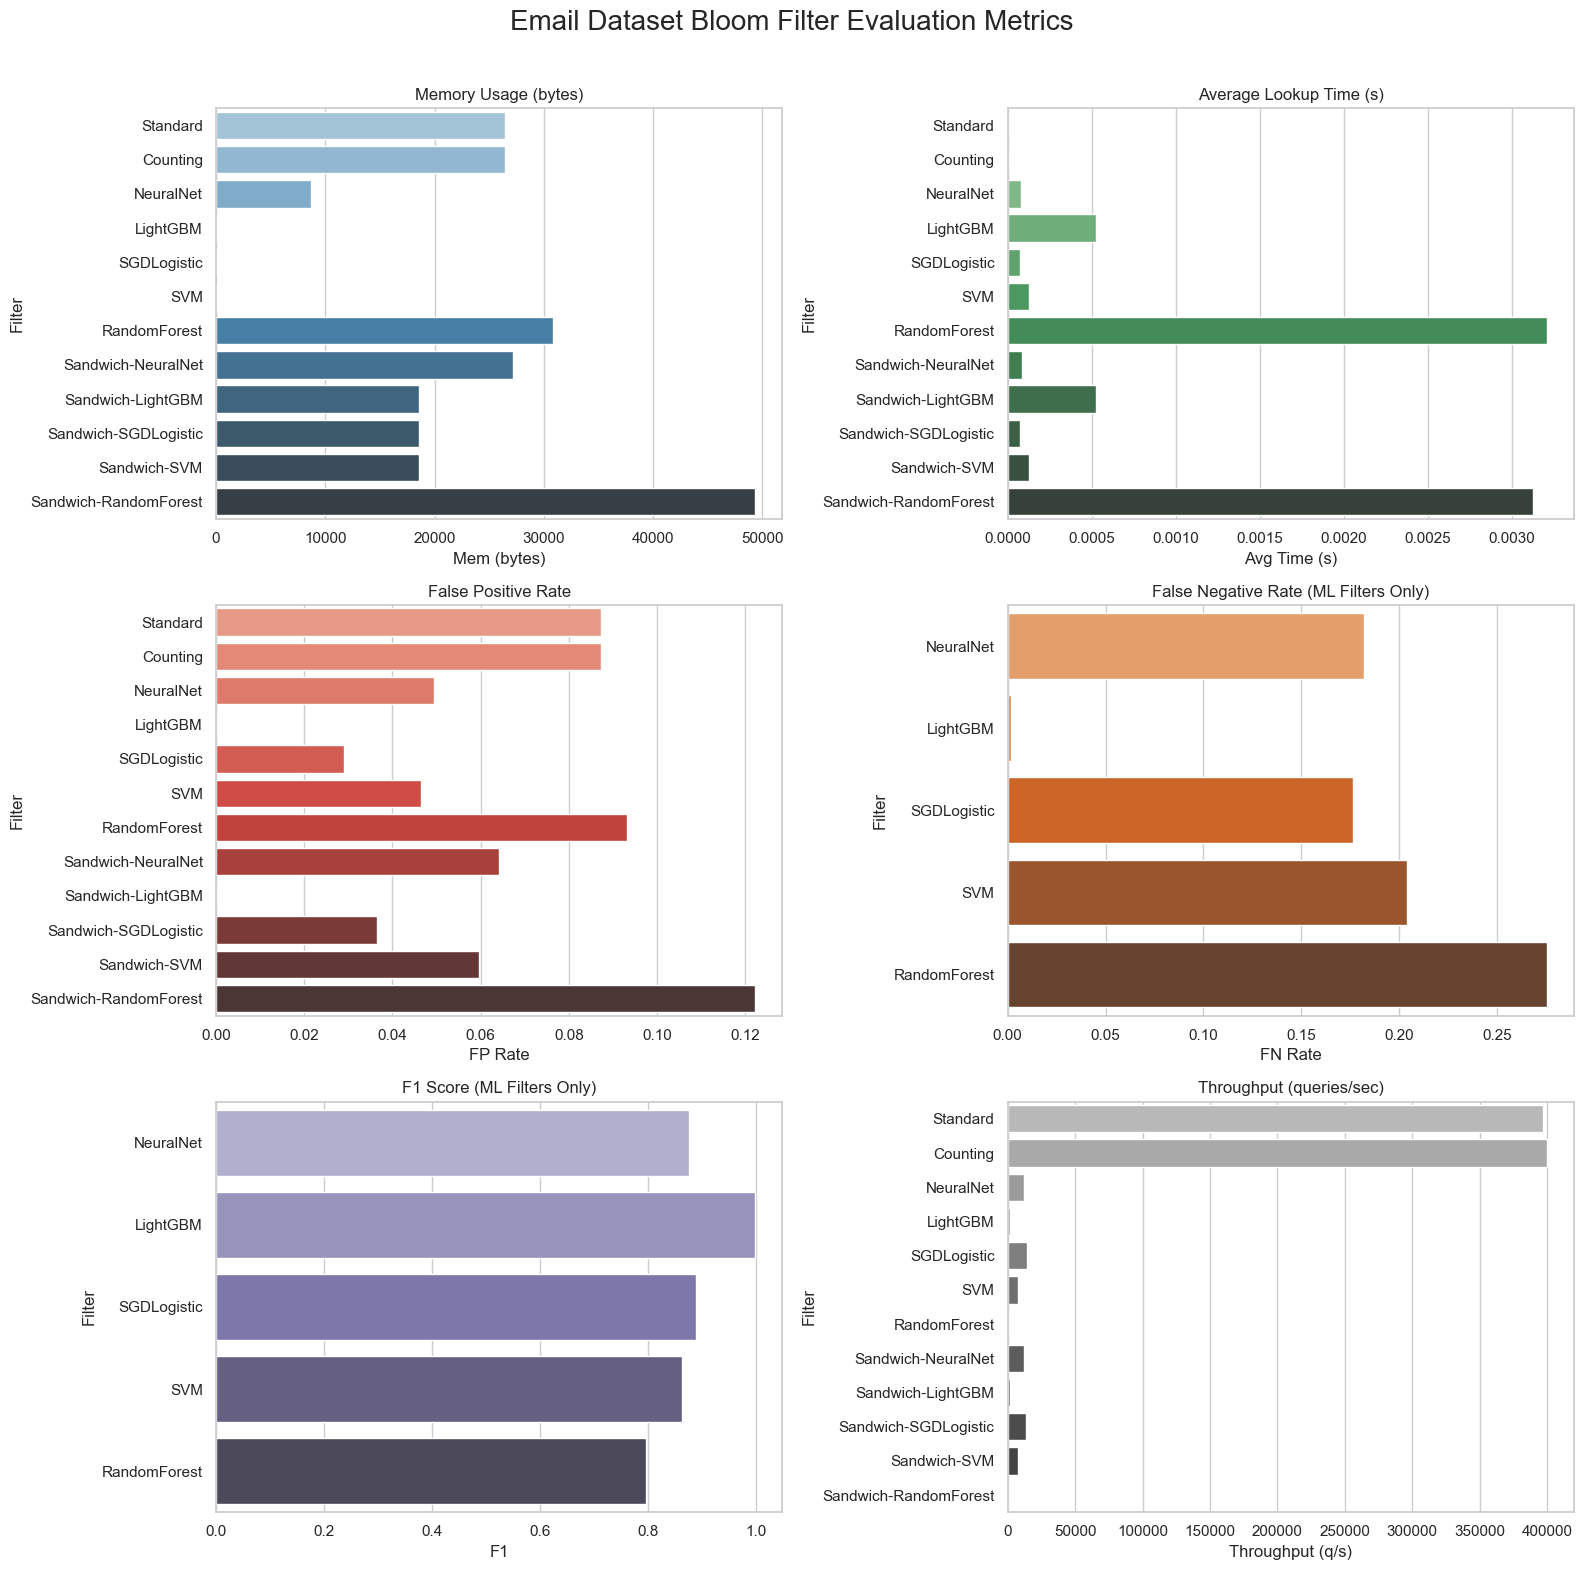

DataFrame saved to: plots/Email_Dataset/Email_Dataset_results.csv


,Filter,Mem (bytes),FP Rate,FN Rate,Avg Time (s),Throughput (q/s),F1
0,Standard,26408,0.087336,NaN,0.000003,396625.856573,NaN
1,Counting,26408,0.087336,NaN,0.000003,399873.278934,NaN
2,NeuralNet,8704,0.049491,0.182216,0.000082,12260.863553,0.875878
3,LightGBM,56,0.000000,0.001458,0.000527,1897.234067,0.999271
4,SGDLogistic,56,0.029112,0.176385,0.000071,14018.082012,0.889064
5,SVM,56,0.046579,0.204082,0.000126,7966.136090,0.863924
6,RandomForest,30872,0.093159,0.275510,0.003207,311.775466,0.797113
7,Sandwich-NeuralNet,27192,0.064047,NaN,0.000085,11830.512095,NaN
8,Sandwich-LightGBM,18544,0.000000,NaN,0.000527,1895.784876,NaN
9,Sandwich-SGDLogistic,18544,0.036390,NaN,0.000073,13706.549815,NaN


In [17]:
df_email = evaluate_dataset(
    "Email Dataset",
    "../datasets/emails/spam_email_positives.txt",
    "../datasets/emails/spam_email_negatives.txt"
)

plot_results(df_email, "Email Dataset")

In [18]:
df_url = evaluate_dataset(
    "URL Dataset",
    "../datasets/urls/url_positives.txt",
    "../datasets/urls/url_negatives.txt"
)

plot_results(df_url, "URL Dataset")


🔍 URL Dataset Bloom Filter Evaluation

[LightGBM] [Info] Number of positive: 44566, number of negative: 40000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2247
[LightGBM] [Info] Number of data points in the train set: 84566, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526997 -> initscore=0.108092
[LightGBM] [Info] Start training from score 0.108092


KeyboardInterrupt: 

In [ ]:
df_passwords = evaluate_dataset(
    "Password Dataset",
    "../datasets/passwords/password_positives.txt",
    "../datasets/passwords/password_negatives.txt"
)

plot_results(df_passwords, "Password Dataset")

In [ ]:
df_ip = evaluate_dataset(
    "IP Address Dataset",
    "../datasets/ip_addresses/ip_address_positives.txt",
    "../datasets/ip_addresses/ip_addresses_negatives.txt"
)

plot_results(df_ip, "IP Address Dataset")


In [ ]:
df_phone = evaluate_dataset(
    "Phone Number Dataset",
    "../datasets/phone_numbers/phone_numbers_positives.txt",
    "../datasets/phone_numbers/phone_numbers_negatives.txt"
)

plot_results(df_phone, "Phone Number Dataset")